# Ejemplo tipos de muestreo:

Vamos a implementar los distintos tipos de muestreo en una población que generaremos aleatoriamente a partir de una distribución normal $N(\mu,\sigma^{2})$.

Usaremos la función `rnorm`:

In [1]:
args(rnorm)

function (n, mean = 0, sd = 1) 
NULL

Los argumentos son:
* `n`:  tamaño deseado
*  `mean`: media (por defecto `0`)
* `sd`: desviación estándar (por defecto `1`)

Simularemos una población pequeña ($n=100.000$), con media $\mu=10$ y desviación estándar $\sigma=5$:

In [2]:
x1<-rnorm(100000, mean = 10, sd = 5)

Para efectos del ejercicio, necesitamos dos variables categóricas: una que nos permita implementar muestreo estratificado y otra muestreo por conglomerados.

Tenemos varias opciones:

* Creamos un factor complejo mediante la función `gl` y unirlos todos
* Creamos un vector de enteros aleatorios donde cada número represente un nivel de cada variable categórica usando la función `sample`

Para la primera variable categórica vamos a emplear la primera opción:

In [3]:
f1<-gl(3, 11, length=30000)
f2<-gl(2, 5, length=30000)
f3<-gl(3, 7, length=40000)
f<-c(f1,f2,f3)

Aquí hemos creado un vector de número enteros (1,2,3) de longitud `100000`, ahora necesitamos convertirlo en factor. Para esto usamos la funcion `factor`:

In [4]:
args(factor)

function (x = character(), levels, labels = levels, exclude = NA, 
    ordered = is.ordered(x), nmax = NA) 
NULL

Los argumentos a tener en cuenta son:

* `x`: vector de datos a transformar
* `levels`: los valores a cambiar
* `labels`: las etiquetas a utilizar

Con lo anterior, y deseando usar los valores `Blanco`, `Negro` y `Rojo`, este factor queda así:

In [5]:
x2<-factor(f, levels = c(1,2,3), labels = c("Blanco","Negro","Rojo"))

El siguiente factor lo simularemos con la función `sample`; deseamos crear cuatro niveles y usaremos los puntos cardinales como etiquetas:

In [6]:
fc<-sample(1:4, 100000, replace= T)
x3<-factor(fc, levels = c(1,2,3,4), labels = c("Norte","Sur","Oriente","Occidente"))

Finalmente, unimos las tres variables para obtener nuestro `data.frame`:

In [7]:
df<-data.frame(x1,x2,x3)
head(df)

x1,x2,x3
<dbl>,<fct>,<fct>
19.126792,Blanco,Sur
8.049879,Blanco,Norte
15.592783,Blanco,Occidente
8.681098,Blanco,Norte
13.076240,Blanco,Oriente
13.859927,Blanco,Occidente


In [8]:
summary(df)

       x1               x2                x3       
 Min.   :-12.768   Blanco:38337   Norte    :25017  
 1st Qu.:  6.631   Negro :38334   Sur      :25079  
 Median : 10.015   Rojo  :23329   Oriente  :25088  
 Mean   :  9.995                  Occidente:24816  
 3rd Qu.: 13.349                                   
 Max.   : 32.083                                   

## MAS

Para todos los casos vamos a definir $100$ como el tamaño muestral. Empezando con el _MAS_. Usamos la función `sample` para generar número aleatorios que representan el número de las filas del `data.frame`:

In [9]:
n100<-100 # Para definir el tamaño de la muestra
muestra100<- sample(1:nrow(df),size=n100,replace=FALSE) # replace = F para no repetir números
head(muestra100)

[1] 27143 50139 40501  8502 39589  1195

Un `data.frame` tiene dos elementos: `filas` y `columnas` que podemos definir asi:
```
df[filas,columnas]
```
con el objeto `muestra100` hemos determinado las filas que seleccionaremos, por lo tanto usamos esos valores para el elemento filas del `data.frame`:

In [10]:
m100<-df[muestra100,]
summary(m100)

       x1               x2             x3    
 Min.   :-0.6068   Blanco:37   Norte    :29  
 1st Qu.: 7.3600   Negro :36   Sur      :25  
 Median : 9.7053   Rojo  :27   Oriente  :23  
 Mean   :10.2645               Occidente:23  
 3rd Qu.:12.7142                             
 Max.   :21.8721                             

## ME

Para el muestreo estratificado necesitamos dos librerías adicionales: `magrittr` y `dplyr`, para usar unas funciones específicas

In [11]:
library(magrittr) # Permite leer la funcion %>% que se usa para asignar funciones a objetos
library(dplyr) # Contiene la funcion select


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Requerimos determinar la proporción correspondiente a cada estrato, vamos a usar las siguientes líneas de comando:

In [12]:
Estratos<- df %>%
  select(x2,x1) %>%
  group_by(x2) %>%
  summarise(n=n(),
            s=sd(x1)) %>%
  mutate(p=n/sum(n))

Estratos

x2,n,s,p
<fct>,<int>,<dbl>,<dbl>
Blanco,38337,5.012791,0.38337
Negro,38334,4.952705,0.38334
Rojo,23329,5.025651,0.23329


Teniendo conocimiento de las proporciones, procedemos a determinar las muestras (recordemos que aún no hemos abordado el tema del tamaño muestral):

In [13]:
library('SamplingUtil') # Contiene la funcion nstrata que nos permite calcular los estratos

In [14]:
nsizeProp100<-nstrata(n=100,wh=Estratos[,4],method="proportional")
data.frame(x2=Estratos$x2,nsizeProp100)

x2,p
<fct>,<dbl>
Blanco,39
Negro,39
Rojo,24


Y procedemos a hacer el MAS dentro de cada estrato:

In [15]:
neBlanco<-39 # Cantidad de sujetos en Blanco
meBlanco100<- sample(1:nrow(df[df$x2=='Blanco',]),size=neBlanco,replace=FALSE)

neNegro<-39 # Cantidad de sujetos en Negro
meNegro100<- sample(1:nrow(df[df$x2=='Negro',]),size=neNegro,replace=FALSE)

neRojo<-24 # Cantidad de sujetos en Rojo
meRojo100<- sample(1:nrow(df[df$x2=='Rojo',]),size=neRojo,replace=FALSE)

mestrato100<-c(meBlanco100,meNegro100,meRojo100) # Unimos los tres vectores

me100<-df[mestrato100,] # Extraemos la muestra

head(me100)

,x1,x2,x3
,<dbl>,<fct>,<fct>
35156,7.777611,Negro,Oriente
5730,10.194740,Negro,Sur
1999,5.682419,Negro,Occidente
28389,11.654443,Blanco,Occidente
32735,13.493746,Blanco,Norte
19673,8.954893,Blanco,Sur


## MS

El muestreo sistemático conlleva a escoger observaciones que ocupan un lugar específico en la lista de datos. Para ellos nos apoyamos en la función `sys.sample` de la librería `SampligUtil`:

In [16]:
library(SamplingUtil)
msis100<- sys.sample(N=nrow(df),n=100)
head(msis100)

[1]  452 1452 2452 3452 4452 5452

In [17]:
m100sis<- df[msis100, ]
head(m100sis)

,x1,x2,x3
,<dbl>,<fct>,<fct>
452,6.150656,Rojo,Sur
1452,6.877552,Rojo,Sur
2452,7.650281,Blanco,Oriente
3452,9.382525,Negro,Oriente
4452,11.701085,Rojo,Oriente
5452,13.901178,Blanco,Norte


## MC

El muestreo por conglomerados se realiza de manera similar al muestreo estratificado. La diferencia radica en las características de la variable categórica que debe hacer referencia a un lugar geográfico. En el ejemplo es `x3` que describe los cuatro puntos cardinales. El procedimiento es:

In [18]:
Conglomerados<- df %>%
  select(x3,x1) %>%
  group_by(x3) %>%
  summarise(n=n(),
            s=sd(x1)) %>%
  mutate(p=n/sum(n))

Conglomerados

x3,n,s,p
<fct>,<int>,<dbl>,<dbl>
Norte,25017,5.005887,0.25017
Sur,25079,5.010662,0.25079
Oriente,25088,4.977485,0.25088
Occidente,24816,4.976974,0.24816


In [19]:
nsCProp100<-nstrata(n=100,wh=Conglomerados[,4],method="proportional")
data.frame(x3=Conglomerados$x3,nsCProp100)

x3,p
<fct>,<dbl>
Norte,26
Sur,26
Oriente,26
Occidente,25


In [20]:
nCoNorte<-26
mCoNorte100<- sample(1:nrow(df[df$x3=='Norte',]),size=nCoNorte,replace=FALSE)

nCoSur<-26
mCoSur100<- sample(1:nrow(df[df$x3=='Sur',]),size=nCoSur,replace=FALSE)

nCoOriente<-26
mCoOriente100<- sample(1:nrow(df[df$x3=='Oriente',]),size=nCoOriente,replace=FALSE)

nCoOccidente<-25
mCoOccidente100<- sample(1:nrow(df[df$x3=='Occidente',]),size=nCoOccidente,replace=FALSE)

mCong100<-c(mCoNorte100,mCoSur100,mCoOriente100,mCoOccidente100)
mc100<-df[mCong100,]

head(mc100)

,x1,x2,x3
,<dbl>,<fct>,<fct>
3761,8.988457,Rojo,Occidente
17802,9.913411,Negro,Norte
15866,8.687524,Rojo,Norte
18550,11.732728,Blanco,Norte
8781,13.626400,Blanco,Sur
10818,5.644709,Rojo,Occidente


Hagamos una comparación gráfica:

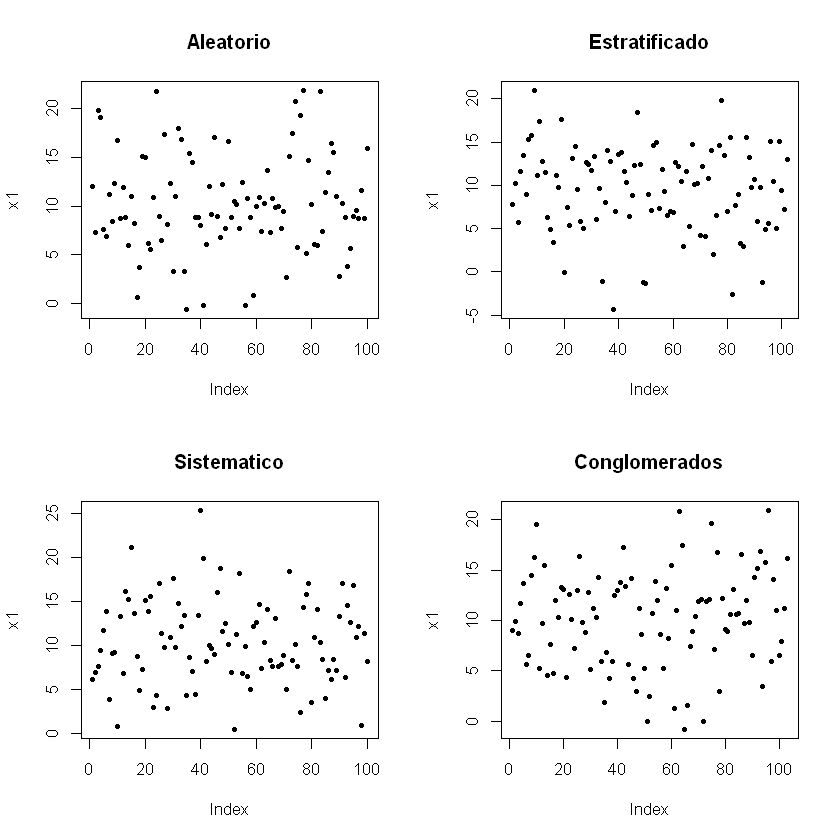

In [21]:
par(mfrow=c(2,2))
with(m100, plot(x1, pch=20, main = 'Aleatorio'))
with(me100, plot(x1, pch=20, main = 'Estratificado'))
with(m100sis, plot(x1, pch=20, main = 'Sistematico'))
with(mc100, plot(x1, pch=20, main = 'Conglomerados'))

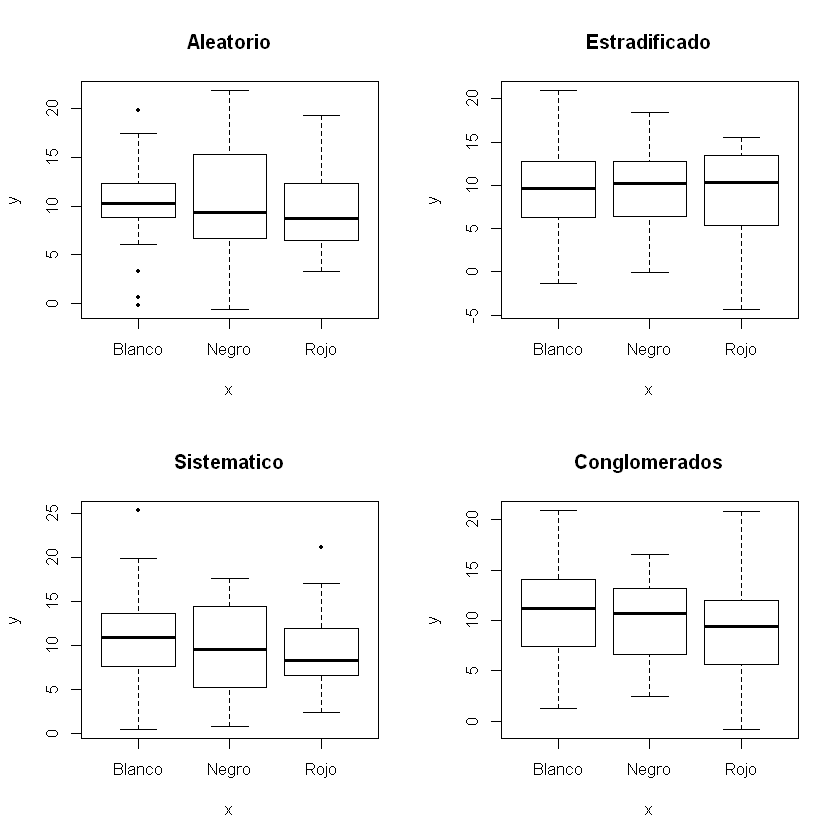

In [22]:
par(mfrow=c(2,2))
with(m100, plot(x2,x1, pch=20, main = 'Aleatorio'))
with(me100, plot(x2,x1, pch=20, main = 'Estradificado'))
with(m100sis, plot(x2,x1, pch=20, main = 'Sistematico'))
with(mc100, plot(x2,x1, pch=20, main = 'Conglomerados'))

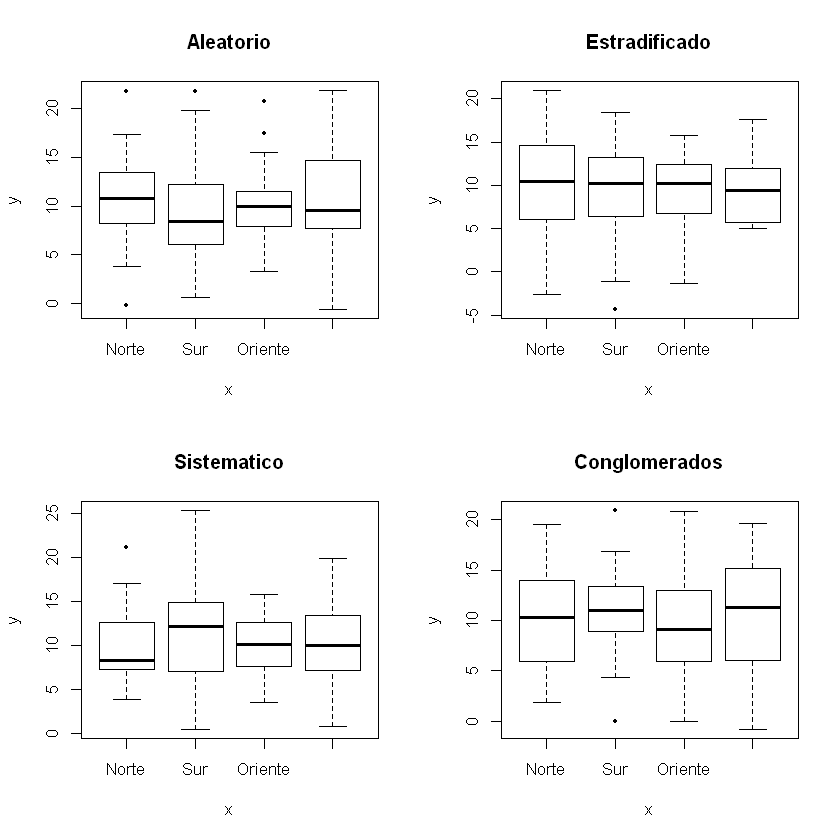

In [23]:
par(mfrow=c(2,2))
with(m100, plot(x3,x1, pch=20, main = 'Aleatorio'))
with(me100, plot(x3,x1, pch=20, main = 'Estradificado'))
with(m100sis, plot(x3,x1, pch=20, main = 'Sistematico'))
with(mc100, plot(x3,x1, pch=20, main = 'Conglomerados'))

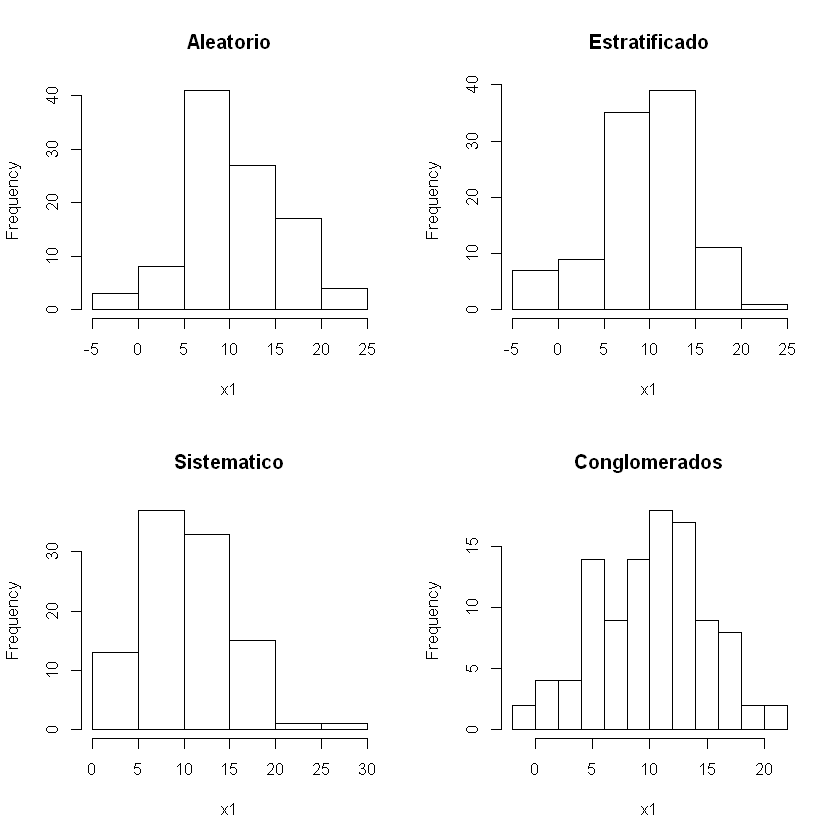

In [24]:
par(mfrow=c(2,2))
with(m100, hist(x1, main = 'Aleatorio'))
with(me100, hist(x1, main = 'Estratificado'))
with(m100sis, hist(x1, main = 'Sistematico'))
with(mc100, hist(x1, main = 'Conglomerados'))

## EJERCICIO

Pruebe con varios tamaños de muestra, compare los resultados y discútalos con sus compañeros; use las funciones `mystas` Y `summary` para los resultados numéricos

### Función `mystats`:

```
mystats <- function(x, na.omit=FALSE){
  if (na.omit)
    x <- x[!is.na(x)]
  m <- mean(x)
  n <- length(x)
  s <- sd(x)
  skew <- sum((x-m)^3/s^3)/n
  kurt <- sum((x-m)^4/s^4)/n - 3
  return(c('tamaño'=n, 'media'=m, "desviación estándar"=s,
           'simetría'=skew, 'kurtosis'=kurt))
}
```

Simule otra población, esta vez de tamaño $500.000$; construya dos variables de estratos, uno de dos niveles y otros de tres niveles y ua variable de conglomerados para las regiones de Colombia: _Caribe_, _Pacífico_, _Andina_, _Amazonía_ y _Orinoquía_; procure que sea parecida a la realidad nacional. Use los siguientes valores para la media y la desviación estándar de la población a simular:

```
 [1] 1112420.0  991186.8  479001.0  577993.2  772165.4 1045078.5 1232893.1  661851.7 
 [9]  830702.7  819056.6  837199.7  803178.7  828598.7  411176.3  926617.9  705401.8
[17]  843941.3  759118.5 1015989.7  845487.1  965037.1  760726.4 1205077.8  557838.5
[25]  733327.0
```

